READ ME

This file can be run without any user input, it is broken into 3 sections with three graphs to be MaxCut with increases number of nodes and cuts to make. The QAOA work is done in the first section to define the circuits to be called as function and then the actual results are visible with the scipy optimization to classically feed the algorithm a range of angles to test the QAOA

In [152]:
from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, pauli_error)
from qiskit.providers.fake_provider import FakeJakartaV2

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from operator import itemgetter

Setting up the regular bit flip noise model for the noisy simulator

In [153]:
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

sim = AerSimulator()
noisy_sim = AerSimulator(noise_model = noise_bit_flip)
backend = FakeJakartaV2()
shots = 20000

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'measure', 'u2', 'cx', 'u3', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Max Cut Optimization

## Creating a network with 5 nodes(qubits)

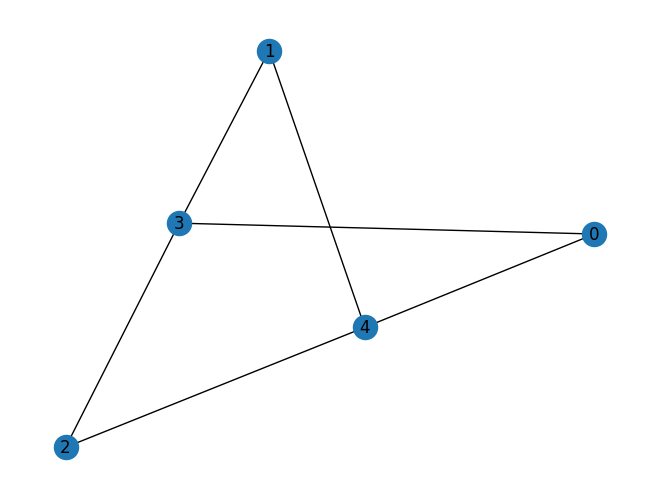

In [30]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, with_labels=True)
N = G.number_of_nodes()

Separator and Mixer Functions defined

In [174]:
def separator(qv, gamma):
    for pair in list(G.edges()):
        qv.cx(pair[0], pair[1])
        qv.rz(2 * gamma, pair[1])
        qv.cx(pair[0], pair[1])
        qv.barrier()
    return qv

def mixer_1(qv, beta):
    for i in range(0, N):
        qv.rx(2 * beta, i)
    qv.barrier()
    return qv

def mixer_2(qv, beta):
    for i in range(0, N):
        qv.ry(2*beta, i)
    qv.barrier()
    return qv

Fuchs, F. G., Lye, K. O., Nilsen, H. M., Stasik, A. J., & Sartor, G. (June 2022). Constraint preserving mixers for QAOA. Give me information on the types of Mixers I can construct for my QAOA problem.

For a given $\gamma$ and $\beta$, this is one layer of circuit execution

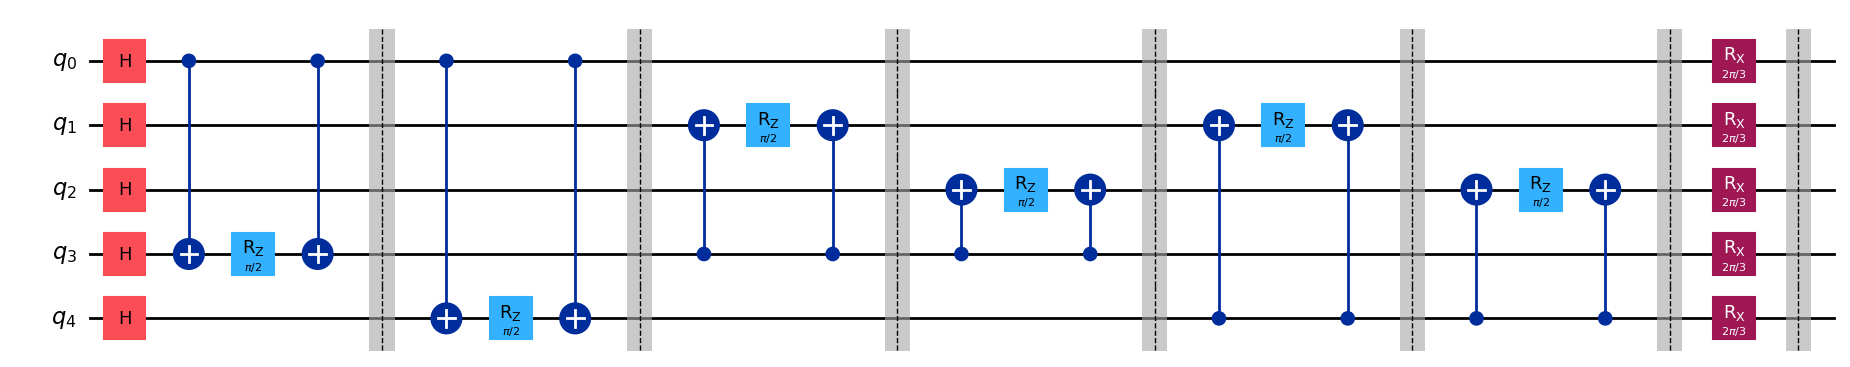

In [106]:
qv = QuantumCircuit(N)
for q in range(N):
    qv.h(q)
separator(qv, gamma = np.pi/4)
mixer_1(qv, beta = np.pi/3)
qv.draw(output = 'mpl', fold = -1, style = 'iqp')

Multiple layers for many more $\gamma_i$ and $\beta_i$, letting p = 3 in our tests for MaxCut

In [111]:
def layering_1(qv, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    for q in range(N):
        qv.h(q)
    for i in range(p):
        separator(qv, gamma[i])
        mixer_1(qv, beta[i])
    qv.measure_all()
    return qv

def layering_2(qv, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    for q in range(N):
        qv.h(q)
    for i in range(p):
        separator(qv, gamma[i])
        mixer_2(qv, beta[i])
    qv.measure_all()
    return qv

The information from the QAOA circuit now needs to be parametrized for our MaxCut

In [97]:
def maxcut_obj(x):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut -= 1
    return cut

def maxcut_cost_funct(meas_res):
    energy = 0
    for meas in meas_res.keys():
        for prob in meas_res.values():
            obj_for_meas = maxcut_obj(meas)
            energy += obj_for_meas * prob
    return energy

In [134]:
p = 3

#The circuit execution with Mixer 1 and Noisy Sim
def quantum_objective_noisy(angles):
    qv_p = QuantumCircuit(N)
    beta = angles[:p]
    gamma = angles[p:]
    qv = layering_1(qv_p,beta, gamma)
    results = execute(qv, noisy_sim, shots=shots).result().get_counts()
    return maxcut_cost_funct(results)

#The circuit execution with Mixer 2 and Noisy Sim
def quantum_objective_noisy_2(angles):
    qv_p = QuantumCircuit(N)
    beta = angles[:p]
    gamma = angles[p:]
    qv = layering_2(qv_p,beta, gamma)
    results = execute(qv, noisy_sim, shots=shots).result().get_counts()
    return maxcut_cost_funct(results)

#The circuit execution with Mixer 1 and Backend
def quantum_objective_backend(angles):
    qv_p = QuantumCircuit(N)
    beta = angles[:p]
    gamma = angles[p:]
    qv = layering_1(qv_p,beta, gamma)
    transpiled_circuit = transpile(qv, backend)
    job = backend.run(transpiled_circuit)
    results = job.result().get_counts()
    return maxcut_cost_funct(results)

#The circuit execution with Mixer 2 and Backend
def quantum_objective_backend_2(angles):
    qv_p = QuantumCircuit(N)
    beta = angles[:p]
    gamma = angles[p:]
    qv = layering_1(qv_p,beta, gamma)
    transpiled_circuit = transpile(qv, backend)
    job = backend.run(transpiled_circuit)
    results = job.result().get_counts()
    return maxcut_cost_funct(results)

Results with Mixer 1 on Noisy Sim

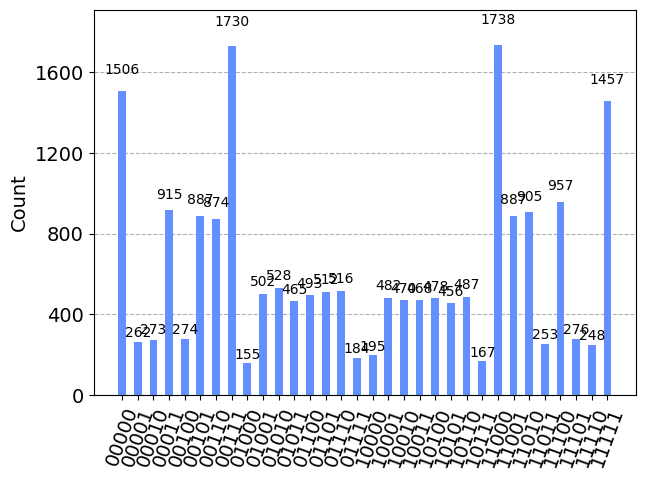

In [137]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 11100 with cut: 6


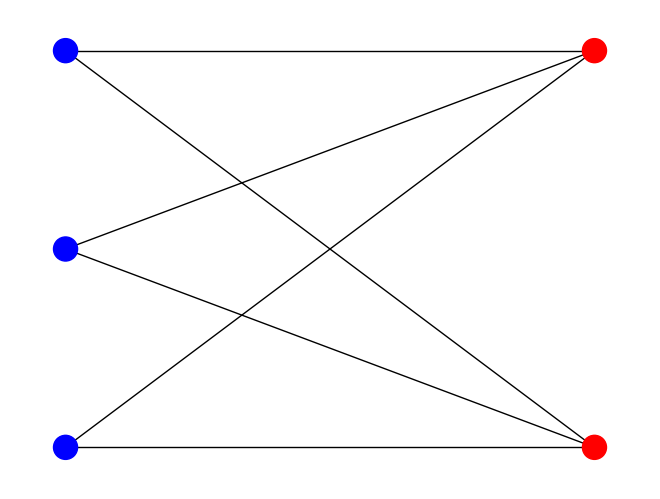

In [138]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 on Noisy Sim

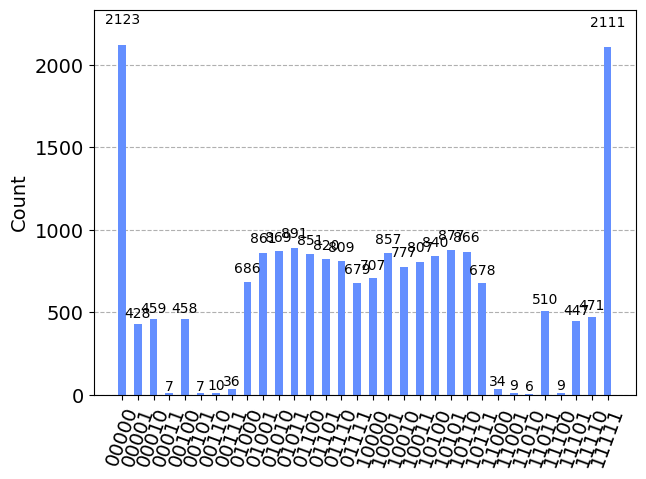

In [139]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 00011 with cut: 6


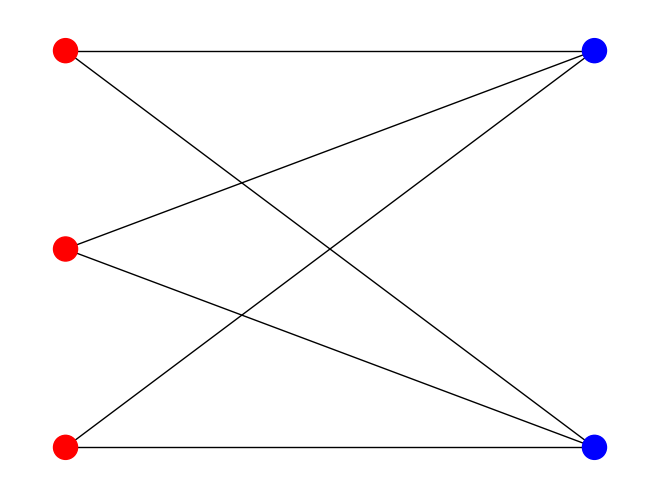

In [136]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 1 with Backend

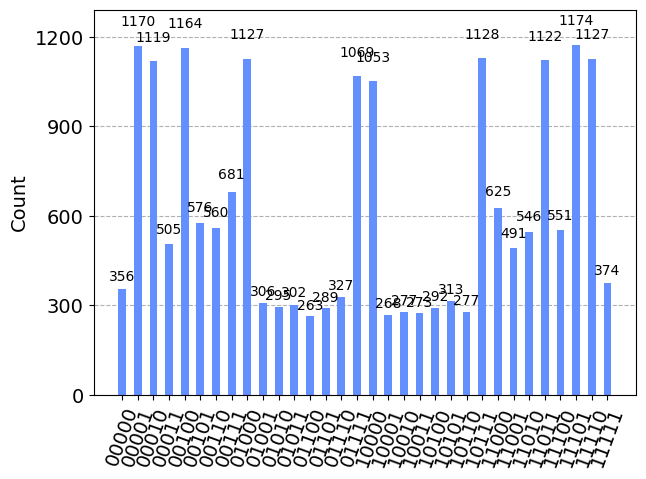

In [140]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 00011 with cut: 6


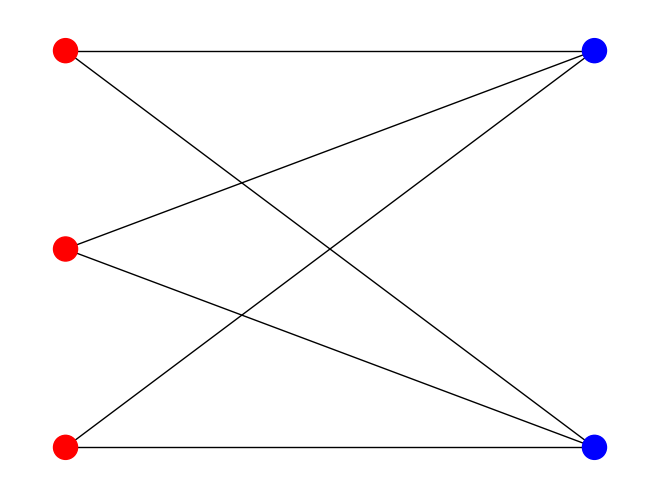

In [141]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 with Backend

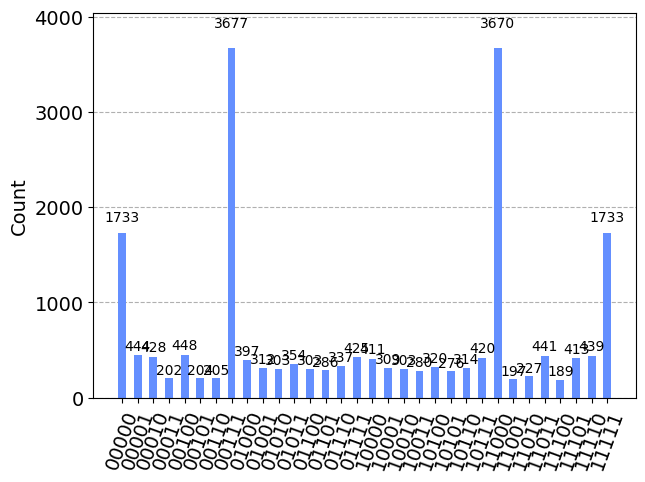

In [142]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 00011 with cut: 6


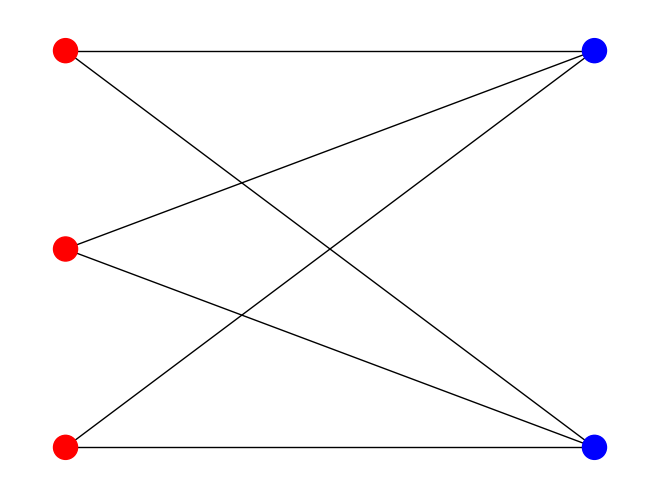

In [143]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### For larger N = 6

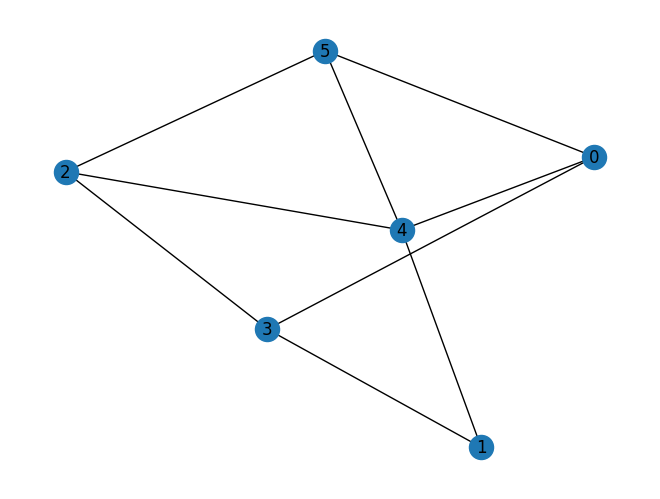

In [144]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4],[5,0],[5,4],[5,2]])
nx.draw(G, with_labels=True)
N = G.number_of_nodes()

Results with Mixer 1 and Noisy Sim

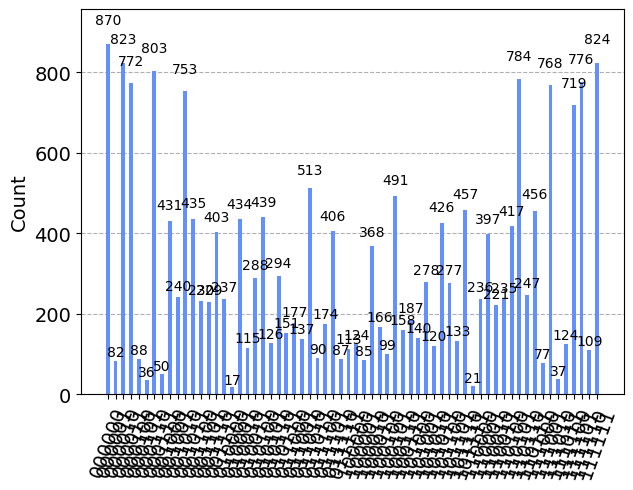

In [145]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 111000 with cut: 8


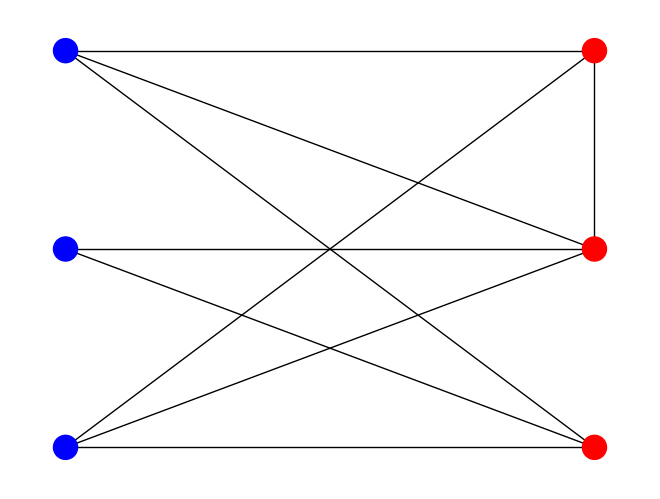

In [146]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 and Noisy Sim

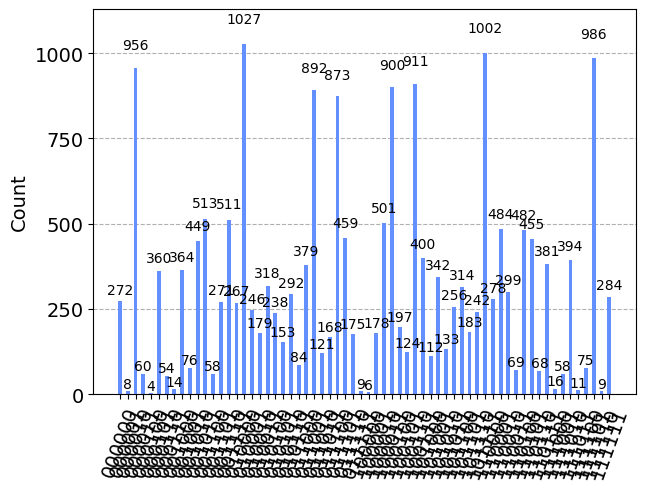

In [147]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 111000 with cut: 8


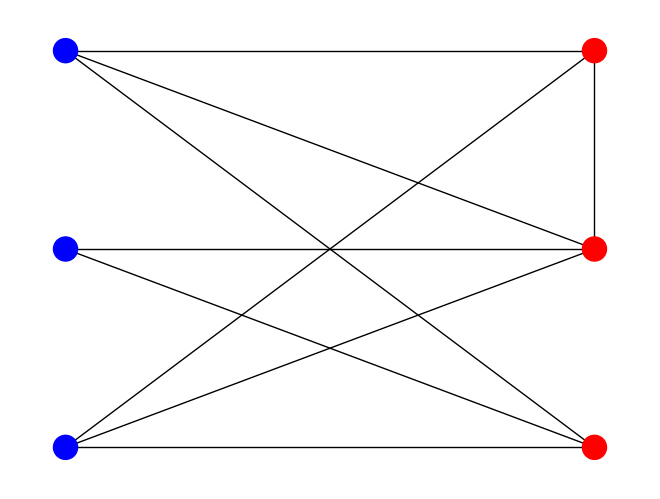

In [148]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 1 and Backend

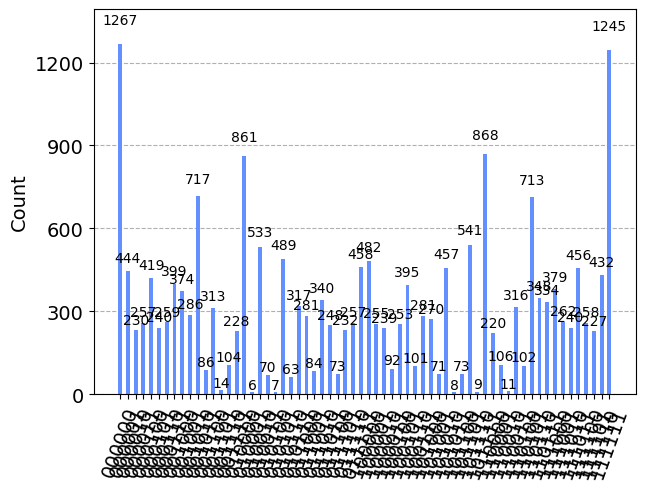

In [154]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 000111 with cut: 8


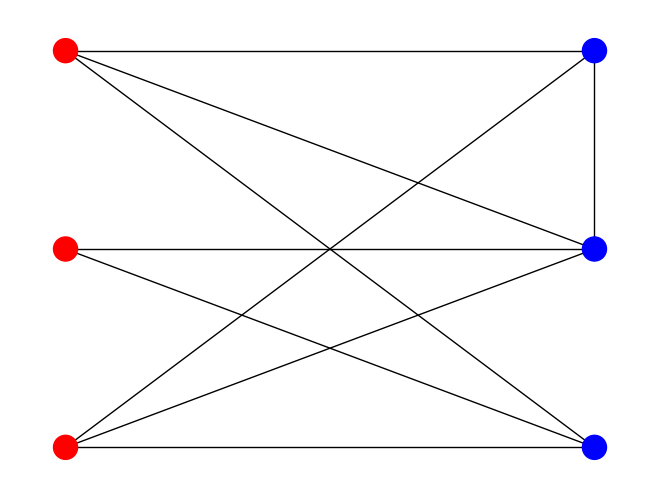

In [155]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 and Backend

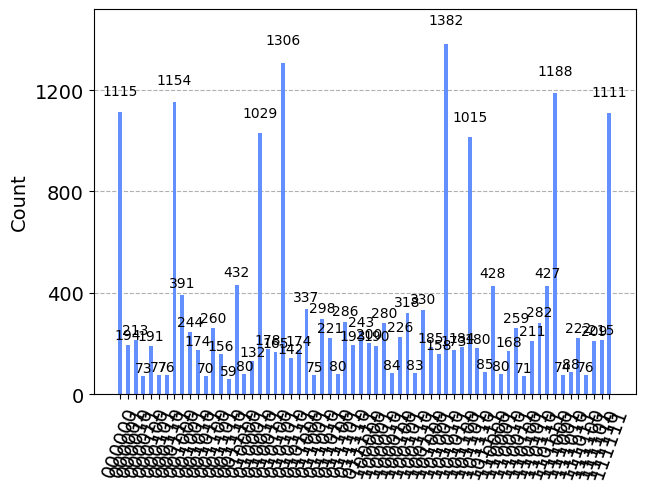

In [156]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 000111 with cut: 8


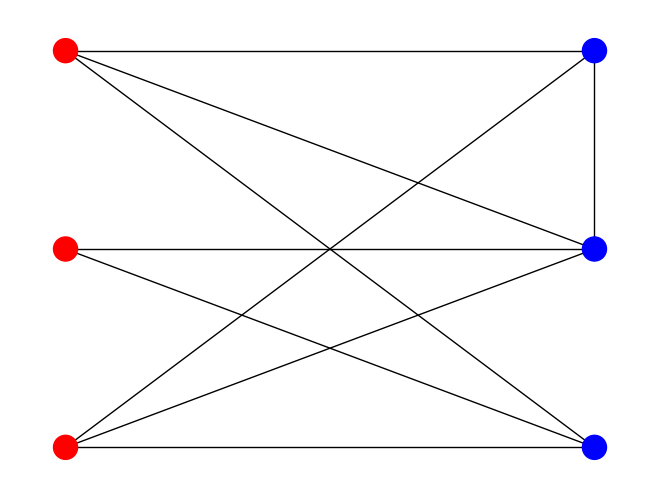

In [157]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### For larger N = 7

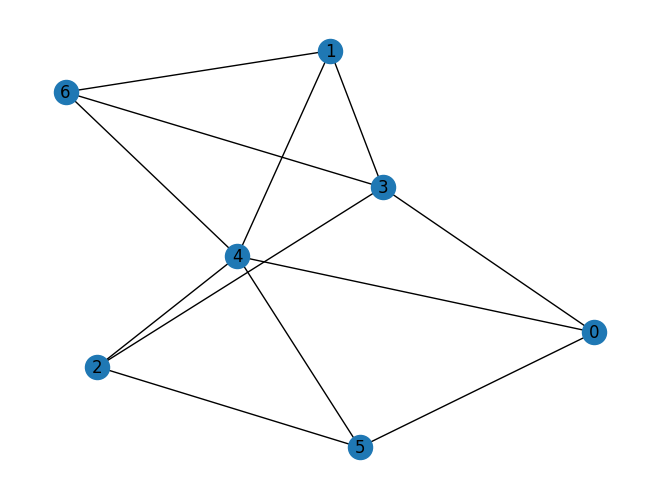

In [158]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4],[5,0],[5,4],[5,2],[6,3],[6,1],[6,4]])
nx.draw(G, with_labels=True)
N = G.number_of_nodes()

Results with Mixer 1 and Noisy Sim

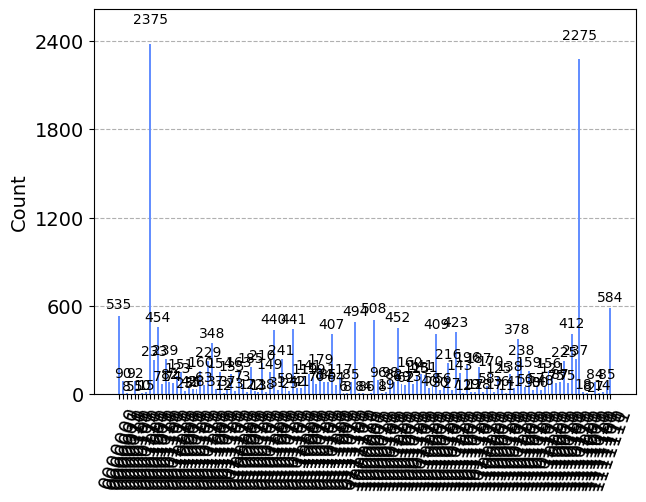

In [159]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 0001110 with cut: 10


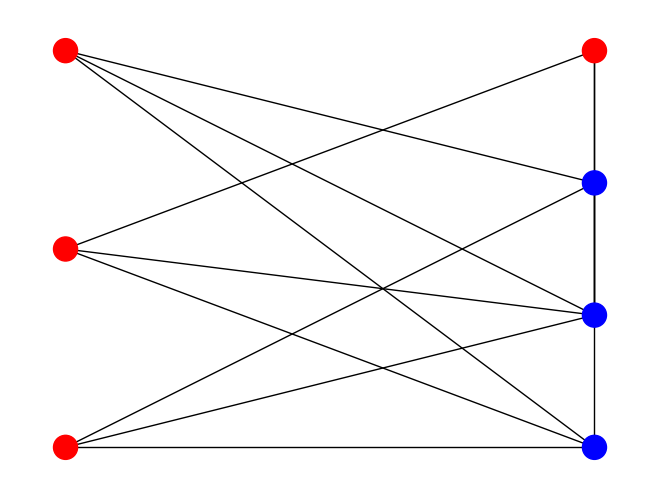

In [160]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 and Noisy Sim

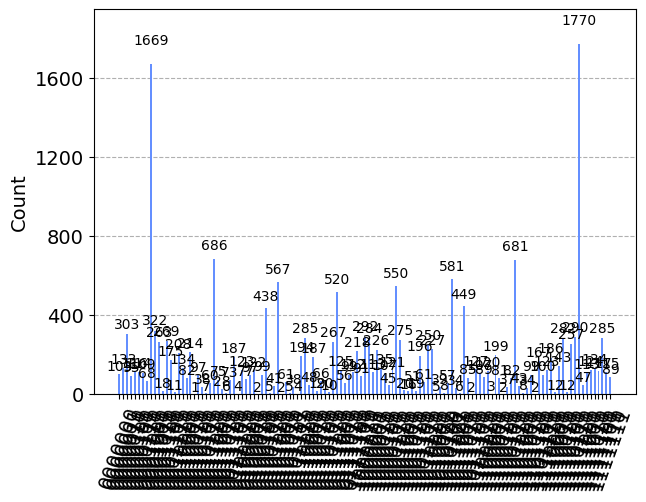

In [161]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_noisy_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 1110001 with cut: 10


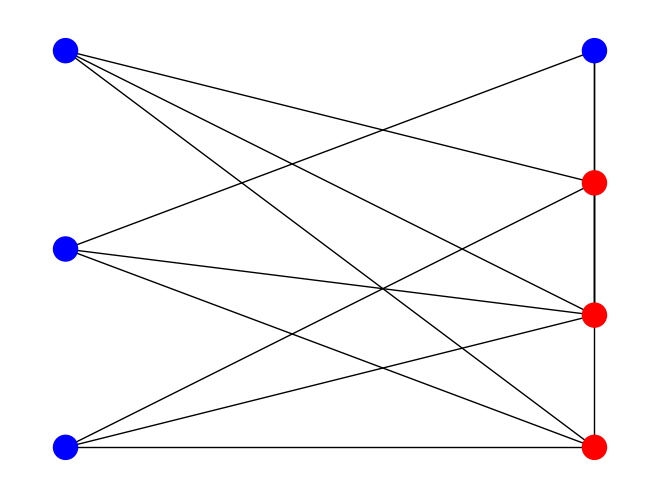

In [162]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 1 and Backend

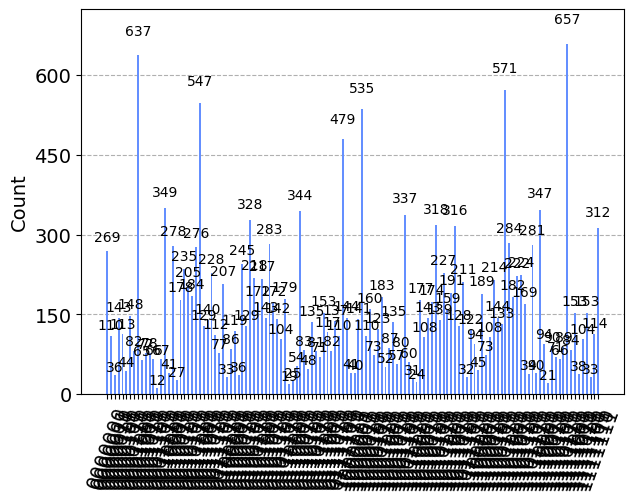

In [163]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 1110001 with cut: 10


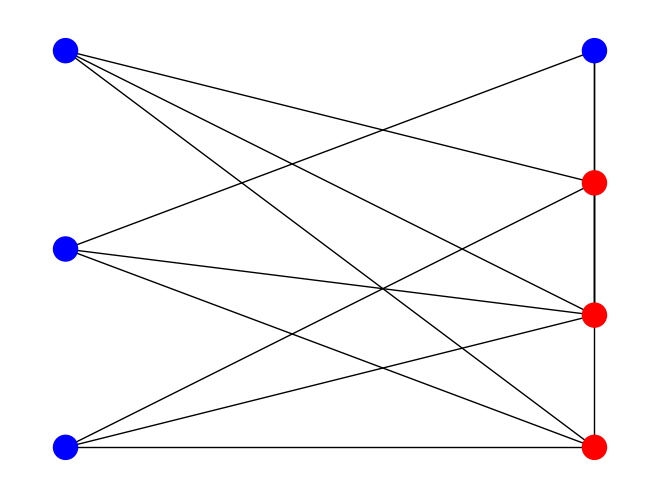

In [164]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

Results with Mixer 2 and Backend

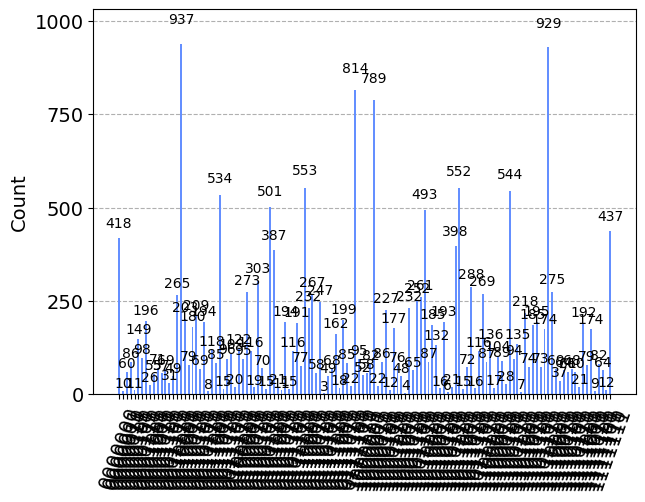

In [166]:
init_point = np.pi * np.random.rand(2 * p)
res_sample = minimize(quantum_objective_backend_2, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumCircuit(N)
qv = layering_1(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = execute(qv, sim, shots=shots).result().get_counts()
diagram = plot_histogram(counts); diagram

Best string: 0001110 with cut: 10


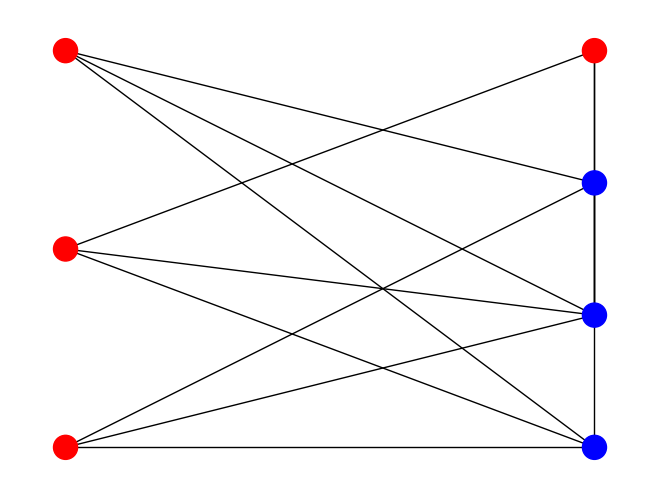

In [167]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

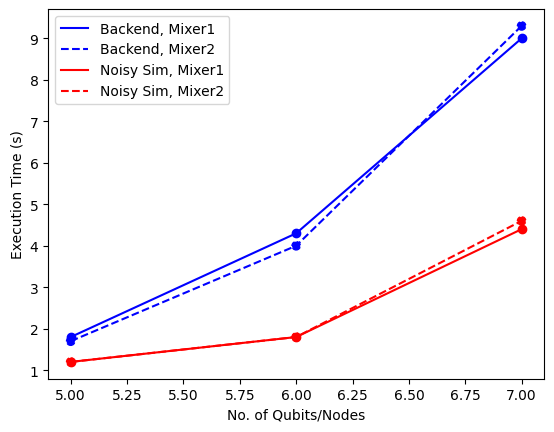

In [173]:
n = [5, 6, 7]

t_backend_1 = [1.8,4.3,9.0]
t_backend_2 = [1.7,4.0,9.3]

t_noisy_1 = [1.2,1.8,4.4]
t_noisy_2 = [1.2,1.8,4.6]

plt.plot(n, t_backend_1, color = 'b',label = 'Backend, Mixer1')
plt.plot(n, t_backend_2,color = 'b',linestyle = 'dashed',label = 'Backend, Mixer2')
plt.plot(n, t_noisy_1,color = 'r',label = 'Noisy Sim, Mixer1')
plt.plot(n, t_noisy_2,color = 'r', linestyle = 'dashed',label = 'Noisy Sim, Mixer2')
plt.scatter(n, t_backend_1, color = 'b')
plt.scatter(n, t_backend_2, linestyle = 'dashed',color = 'b')
plt.scatter(n, t_noisy_1,color = 'r')
plt.scatter(n, t_noisy_2, linestyle = 'dashed',color = 'r')
plt.legend(loc = 'upper left')
plt.xlabel('No. of Qubits/Nodes')
plt.ylabel('Execution Time (s)')
plt.show()